# JFC #1 Processing Sandbox

In [1]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
import pandas as pd
import os.path as path
import datetime as dt
import warnings
import seaborn as sb
import cosmicsense as cs
import glob
import os
import copy
import shapefile
import matplotlib.animation as animation

In [2]:
warnings.simplefilter('once', RuntimeWarning)

In [3]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

### Collecting meteo data

From DWD at Hohenpeißenberg:
- Precipitation: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_02290_akt.zip
- Temperature and humidity: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_02290_akt.zip
- Pressure: ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_02290_akt.zip

In [4]:
f_prec = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_RR_02290_akt.txt"
prec = pd.read_csv(f_prec, sep=";", na_values=-999)
prec.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec.datetime = pd.to_datetime(prec.datetime, format="%Y%m%d%H")
prec = prec.set_index("datetime")

In [5]:
f_press = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_P0_02290_akt.txt"
press = pd.read_csv(f_press, sep=";", na_values=-999)
press.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press.datetime = pd.to_datetime(press.datetime, format="%Y%m%d%H")
press = press.set_index("datetime")

In [6]:
f_temphum = "/media/x/cosmicsense/data/fendt/dwd/stundenwerte_TU_02290_akt.txt"
temphum = pd.read_csv(f_temphum, sep=";", na_values=-999)
temphum.columns = ["station_id", "datetime", "quality", "temp2m", "relhum2m", "eor"]
temphum.datetime = pd.to_datetime(temphum.datetime, format="%Y%m%d%H")
temphum = temphum.set_index("datetime")

In [7]:
f_meteo = "/media/x/cosmicsense/data/fendt/meteo/2019_metDataDE-Fen.dat"
names = ["datetime","temp2m","press2m","relhum2m","windsp2m","winddir2m","swdownrad2m","lwdownrad2m","precip"]
meteo = pd.read_csv(f_meteo, sep=",", skiprows=2, names=names)
meteo.datetime = pd.to_datetime(meteo.datetime)
meteo = meteo.set_index("datetime")
meteo.index = meteo.index.tz_convert(None)

In [8]:
meteo["abshum2m"] = cs.conv.absolute_humidity(meteo.temp2m, meteo.relhum2m)
temphum["abshum2m"] = cs.conv.absolute_humidity(temphum.temp2m, temphum.relhum2m)

/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


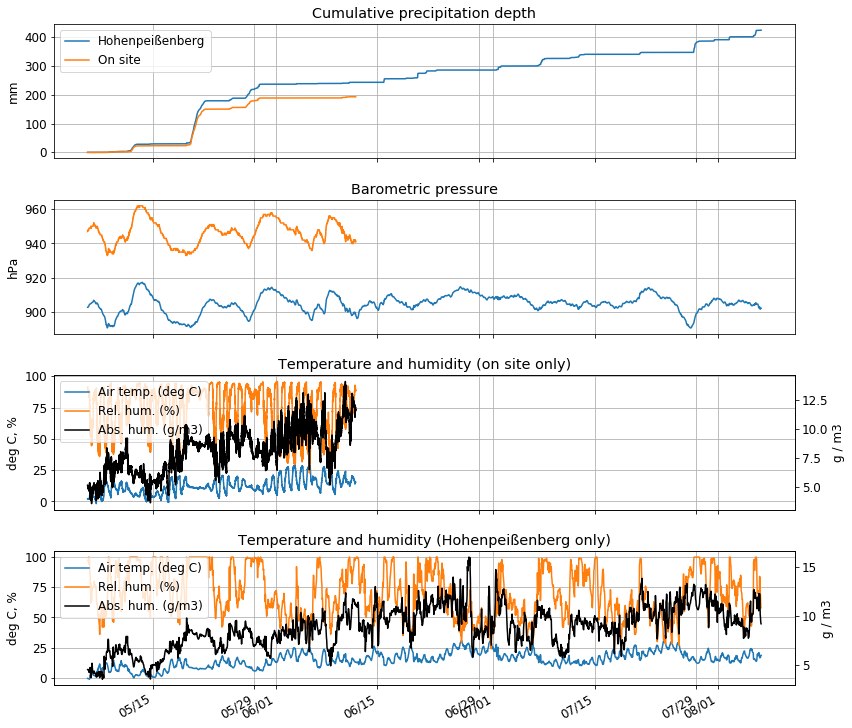

In [9]:
plt.rc('font', **{'size'   : 12})
fig = plt.figure(figsize=(12, 12))

ax = plt.subplot(411)
plt.plot(prec["2019-05-06":].index, prec["2019-05-06":].depth.cumsum(), label="Hohenpeißenberg")
plt.plot(meteo["2019-05-06":].index, meteo["2019-05-06":].precip.cumsum(), label="On site")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
plt.title("Cumulative precipitation depth")
plt.legend()
plt.ylabel("mm")
xlim = ax.get_xlim()

ax = plt.subplot(412)
plt.plot(press["2019-05-06":].index, press["2019-05-06":].p0, label="Hohenpeißenberg")
plt.plot(meteo["2019-05-06":].index, meteo["2019-05-06":].press2m, label="On site")
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Barometric pressure")
plt.ylabel("hPa")

ax = plt.subplot(413)
#plt.plot(press["2019-05-06":].index, press["2019-05-06":].p0, label="Hohenpeißenberg")
templ = plt.plot(meteo["2019-05-06":].index, meteo["2019-05-06":].temp2m, label="Air temp. (deg C)")
rehumpl = plt.plot(meteo["2019-05-06":].index, meteo["2019-05-06":].relhum2m, label="Rel. hum. (%)")
plt.grid()
plt.ylabel("deg C, %")
ax2 = ax.twinx()
abshumpl = plt.plot(meteo["2019-05-06":].index, meteo["2019-05-06":].abshum2m, color="black", label="Abs. hum. (g/m3)")
lns = templ+rehumpl+abshumpl
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Temperature and humidity (on site only)")
plt.ylabel("g / m3")
plt.tight_layout()
ax.set_xlim(xlim)

ax = plt.subplot(414)
templ = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].temp2m, label="Air temp. (deg C)")
rehumpl = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].relhum2m, label="Rel. hum. (%)")
plt.grid()
plt.ylabel("deg C, %")
ax2 = ax.twinx()
abshumpl = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].abshum2m, color="black", label="Abs. hum. (g/m3)")
lns = templ+rehumpl+abshumpl
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper left")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Temperature and humidity (Hohenpeißenberg only)")
plt.ylabel("g / m3")
plt.tight_layout()
ax.set_xlim(xlim)

fig.autofmt_xdate()

## Read raw data

#### Read sensor metadata

In [10]:
attrs = pd.read_csv("jfc1table.csv", sep=";")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,id
id,,,,,,,,,,,
1,UP,CRS 2000-B,11.064395,47.825464,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,500,1000,1
2,UP,CRS 1000,11.061651,47.826620,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,500,1100,2
3,UP,CRS 1000,11.059494,47.831677,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,500,1100,3
4,UP,Lab-C,11.061457,47.823908,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6000,9500,4
5,KIT,CRS 1000-B,11.063310,47.828752,True,True,2019-05-29 12:20:00,2019-05-31 08:35:00,800,1500,5
6,KIT,CRS 1000-B,11.064491,47.822520,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,800,1500,6
7,KIT,CRS 1000-B,11.059960,47.828184,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1000,1700,7
8,KIT,CRS 2000-B,11.060487,47.832478,True,True,2019-06-04 16:00:00,2019-06-05 11:53:00,1300,2500,8
9,UFZ,Styx Neutronica,11.066562,47.828935,False,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,9


#### Read sensor data

In [11]:
fpath = "/media/x/cosmicsense/data/fendt/crns/"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS_merge.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    if id==18:
        df = df["2019-05-09 00:00:00":]
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-05-09 09:59:00 to 2019-08-06 06:41:00
2: 2019-05-07 11:02:13 to 2019-08-06 08:46:30
3: 2019-05-07 08:37:25 to 2019-07-16 10:26:00
4: 2019-05-07 15:21:29 to 2019-07-16 13:19:00
5: 2019-05-03 08:53:04 to 2019-07-19 09:29:00
6: 2019-05-03 09:34:48 to 2019-07-19 07:05:00
7: 2019-05-13 14:54:00 to 2019-07-19 09:20:00
8: 2019-05-01 00:46:00 to 2019-07-22 11:46:00
14: 2019-05-08 06:45:44 to 2019-07-23 06:18:00
16: 2019-05-14 13:45:00 to 2019-07-16 16:31:00
17: 2019-05-15 14:14:46 to 2019-07-16 11:46:00
18: 2019-05-14 10:16:06 to 2019-07-17 08:24:00
19: 2019-05-14 12:45:49 to 2019-07-17 12:25:00
21: 2019-05-13 13:38:38 to 2019-07-16 04:17:00
22: 2019-05-13 15:24:44 to 2019-07-15 09:45:00
23: 2019-05-15 15:55:32 to 2019-07-17 04:19:00
24: 2019-05-15 15:09:58 to 2019-07-16 12:39:00
25: 2019-05-14 10:02:00 to 2019-07-19 09:01:00


In [12]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)
# Set max_dtime
max_dtime = dt.datetime(2019, 7, 23)

2019-05-01 00:46:00 - 2019-08-06 08:46:30


### Get calibrator data

crnsdir = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd/20"
tmpfile = "tmpcal"
try:
    os.remove(tmpfile)
except:
    pass
for name in glob.glob(crnsdir+'/**/*'+".cal", recursive=True):
    print("\t", name)
    fin = open(name, "r")
    body = fin.read()
    # replace comment character
    body = body.replace("//", "#")
    # replace zombie line endings
    body = body.replace(",\r\n", "\r\n")
    body = body.replace(",\n", "\n")
    #body = body.replace(",\r", "\r")
    # comment out these lines
    body = body.replace("NPM#1:", "#NPM#1")
    body = body.replace("NPM#2:", "#NPM#2")
    myfile = open(tmpfile, 'a')
    myfile.write(body)
    myfile.close()

cal = pd.read_csv(tmpfile, sep=",", comment="#", header=None, error_bad_lines=False, warn_bad_lines=True)
cal.columns = ["rec_id", "datetime", "pressx", "press1", "press4", "temp1", "relhum1", "volt", "counts1", "nsecs1", "counts2", "nsecs2"]
cal.datetime = pd.to_datetime(cal.datetime, format="%Y/%m/%d %H:%M:%S")
cal = cal.set_index("datetime")
cal.insert(loc=1, column="datetime", value=cal.index)
cal = cal.sort_index()
cal = cal[cal.index >= "2019-05-01"]
dupl = cal.index.duplicated(keep='first')
if np.any(dupl):
    print("Contains %d duplicates" % len(np.where(dupl)[0]))
    cal = cal[~dupl]
fpath = "/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd/20/cal.txt"
cal.to_csv(fpath, sep="\t", index=False, date_format="%Y-%m-%d %H:%M:%S")  

In [13]:
cal = pd.read_csv("/home/maik/b2drop/cosmicsense/inbox/fendt/timeseries/crns/JFC-1-sd/20/cal.txt", sep="\t")
cal.datetime = pd.to_datetime(cal.datetime)
cal = cal.set_index("datetime")
# Accounting for counts in both tubes
cal["cph1"] = (cal.counts1 + cal.counts2) / cs.conv.s_to_h(cal.nsecs1)

#### Manually adjust calibration start and end in order to filter spurious counts

In [14]:
attrs["calstartadj"] = attrs.calstart
attrs["calendadj"] = attrs.calend
attrs.loc[22, "calstartadj"] = pd.Timestamp("2019-05-22 11:00:00")
attrs.loc[22, "calendadj"] = pd.Timestamp("2019-05-23 12:00:00")
attrs.loc[16, "calstartadj"] = pd.Timestamp("2019-05-23 12:45:00")
attrs.loc[4, "calstartadj"] = pd.Timestamp("2019-05-28 15:45:00")
attrs.loc[24, "calstartadj"] = pd.Timestamp("2019-06-26 17:00:00")
attrs.loc[18, "calstartadj"] = pd.Timestamp("2019-06-27 18:10:00")
attrs.loc[13, "calstartadj"] = pd.Timestamp("2019-07-03 09:20:00")
attrs.loc[15, "calstartadj"] = pd.Timestamp("2019-07-04 14:20:00")
attrs.loc[9, "calstartadj"] = pd.Timestamp("2019-07-09 11:20:00")
attrs.loc[17, "calstartadj"] = pd.Timestamp("2019-07-10 14:00:00")

In [15]:
cal["id"] = -9999
for id in attrs[attrs.hascal].id:
    cal.loc[attrs.loc[id,"calstartadj"]:attrs.loc[id,"calendadj"], "id"] = id

In [16]:
calavgcph = cal.groupby('id', as_index=False)['cph1'].mean()

In [ ]:
plt.rc('font', **{'size'   : 12})
colors = plt.cm.tab20(range(len(calavgcph)))
fig = plt.figure(figsize=(12, 5))
ax = plt.subplot(111)
plt.plot(cal.index, cal.cph1, linewidth=0, marker=".", color="black", mfc="None", ms=8, label="unacc.")
plt.grid()
plt.xlim(dt.datetime(2019,5,20), dt.datetime(2019,7,17))
for i,id in enumerate(calavgcph.id):
    if not id==-9999:
        #start = attrs.loc[id,"calstartadj"]
        #end = attrs.loc[id,"calendadj"]
        #tmp = cal[start:end]
        plt.plot(cal.loc[cal.id==id].index, cal[cal.id==id].cph1, linewidth=0, marker=".", ms=8, color=colors[i], label=str(id))
        #plt.plot(tmp.loc[cal.id==id].index, tmp.loc[cal.id==id].cph1, linewidth=0, marker=".", ms=8, color=colors[i], label=str(id))
        plt.plot(attrs.loc[id,["calstartadj", "calendadj"]], np.repeat(calavgcph[calavgcph.id==id].cph1, 2), color="black", label="_tmp")
plt.legend(ncol=2, columnspacing=0.001)
plt.ylabel("Counts per hour)")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

## Filter spurious signals

Some probes are affected by spurious count rates. In order to keep useful parts of the signal, a pragmatic/heuristic filtering approach is applied which could be refined later:

1. Remove entirely unrealisticly count rates for specific probes (`mincph`, `maxcph`)
2. Remove count rates from spuriously short count intervals (`mininterv`)
3. After that, there are still spurious count rates.In order to detect these, we compute the maximum count rates over periods of six hours, and then apply a 24-hour-median filter to these 6-hour-maxima. That way, we try to truncate spurios peaks. In order to prevent too aggressive filtering, we add a `buffer` of the median count rates over a period of 24 hours.
4. We then interpolate this upper limit filter to the original timestamp values and use it to remove high values.
5. We remove unrealisticly low count rates (`mincph`), and than apply the same approach (points 3-4) to eliminate spuriously small values.  

In [18]:
buffer = 0.075
mininterv = 600

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    # Today's specials
    if not key==1:
        #x[x > pars[key]["maxcph"]] = np.nan
        x[x > attrs.loc[key, "maxcph"]] = np.nan
    if key==1:
        x[:"2019-06-06 09:00:00"] = np.nan
    if key==2:
        # Weird behaviour
        x["2019-06-25 10:00:00":"2019-06-25 20:00:00"] = np.nan
        x["2019-06-26 10:00:00":"2019-06-26 20:00:00"] = np.nan
    #x[x < pars[key]["mincph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan        
    x[crns[key].nsecs1 < mininterv] = np.nan
    median24 = x.resample("24H").median()
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    if not key==1:
        crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
        crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

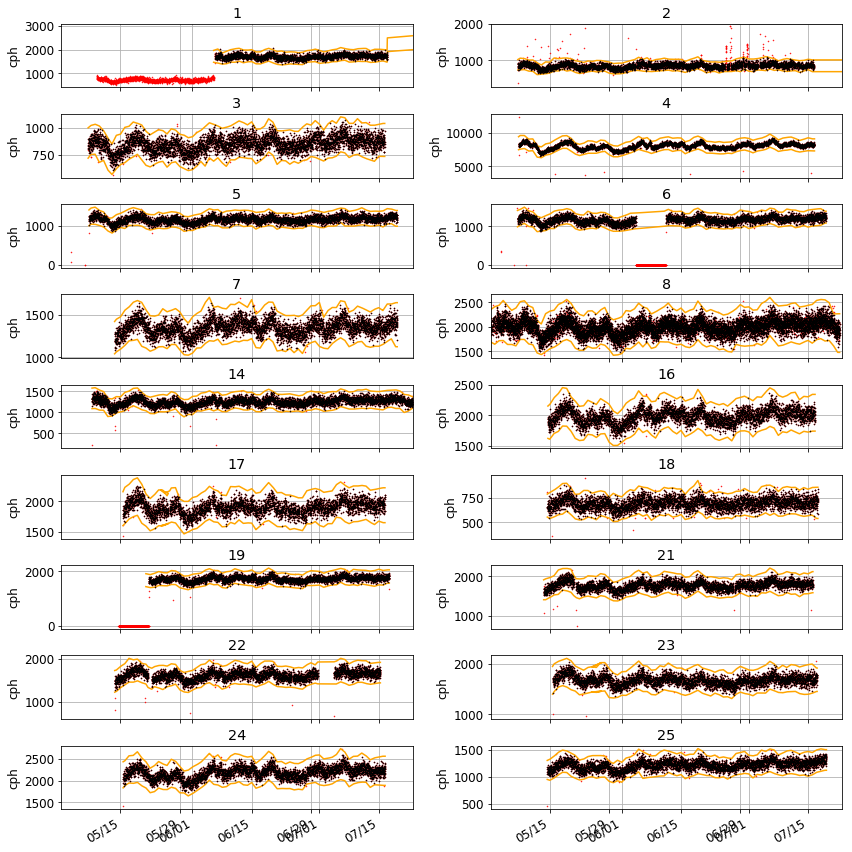

In [19]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(12,12))
ax = ax.ravel()

xlim = min_dtime, dt.datetime(2019,7,23)#max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    #ax[i].set_ylim(pars[key]["mincph"], pars[key]["maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.2)

### Calibrate sensitivity

In [20]:
calfacts = {"CRS 1000": np.array([]), "CRS 1000-B": np.array([]), "CRS 2000": np.array([]),
            "CRS 2000-B": np.array([]), "Lab-C": np.array([]), "Styx Neutronica": np.array([])}
attrs["calfact"] = np.nan
for id in attrs[attrs.hascal & attrs.hasdata].id:
    #if (calperiods[id] is not None) and (id in ids): 
    probeavg = np.nanmean(crns[id][str(attrs.loc[id,"calstart"]):str(attrs.loc[id,"calend"])].cph1)
    ratio = float(probeavg / calavgcph[calavgcph.id==id].cph1)
    attrs.loc[id,"calfact"] = ratio
    calfacts[attrs.loc[id, "type"]] = np.append(calfacts[attrs.loc[id, "type"]], ratio)
for key in calfacts.keys():
    print("%s: %s, mean factor: %.2f" % (key, calfacts[key], np.mean(calfacts[key])) )
for id in attrs[~attrs.hascal & attrs.hasdata].id:
    attrs.loc[id,"calfact"] = np.mean(calfacts[attrs.loc[id,"type"]])

CRS 1000: [0.41357712], mean factor: 0.41
CRS 1000-B: [0.66976865 0.66672533], mean factor: 0.67
CRS 2000: [0.86784024], mean factor: 0.87
CRS 2000-B: [1.16019181 1.14585279 1.12084488 1.1685734  1.12683947 1.13809019], mean factor: 1.14
Lab-C: [4.55460298], mean factor: 4.55
Styx Neutronica: [], mean factor: nan


/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
for id in crns.keys():
    crns[id]["cph1cal"] = crns[id]["cph1_filtered"] / attrs.loc[id, "calfact"]

## Resample to uniform 20 minute interval via nearest neighbour

In [22]:
dtrange = pd.date_range('2019-05-01 00:00:00', max_dtime, freq="20T")
crns20 = pd.DataFrame({}, index=dtrange)

for i, key in enumerate(crns.keys()):
    crns20[key] = crns[key].cph1cal.resample('20T').nearest(limit=1).reindex(dtrange)

In [23]:
#pp = sb.pairplot(crns20)

## Correcting for variations in incoming neutron flux

#### NMBD station data

`nmdb.txt` contains reference (background) neutron count rates from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL2`, `JUNG`, `JUNG1`, and `DRBS` (Dourbes, Belgium). 

In [24]:
# NMDB data
nmdb = pd.read_csv("/media/x/cosmicsense/data/fendt/nmdb/nmdb.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

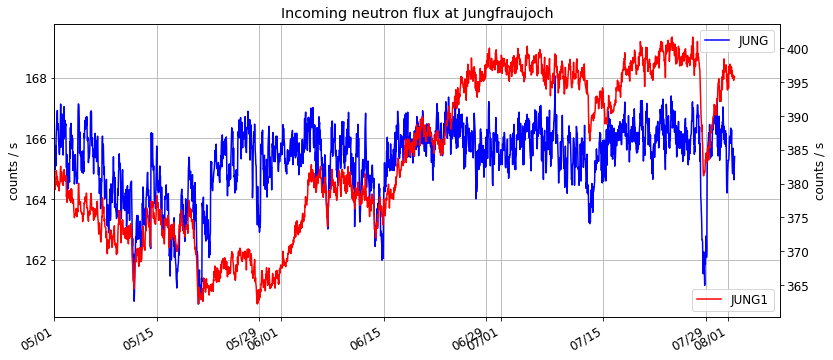

In [25]:
fig, ax1 = plt.subplots(figsize=(13, 6))
plt.plot(nmdb.index, nmdb.JUNG, "b-", label="JUNG")
plt.ylabel("counts / s")
plt.legend()
plt.grid()

ax2 = ax1.twinx()
plt.plot(nmdb.index, nmdb.JUNG1, "r-", label="JUNG1")
plt.ylabel("counts / s")
leg = plt.legend(loc="lower right")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Incoming neutron flux at Jungfraujoch")

fig.autofmt_xdate() 

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch (JUNG).

In [26]:
fi = (nmdb.JUNG / nmdb.JUNG.mean())
fi.name="fi"
fi = fi.resample("1H").mean().resample("20T").ffill().reindex(dtrange)
fi2 = (nmdb.JUNG1 / nmdb.JUNG1.mean())
fi2.name="fi2"
fi2 = fi2.resample("1H").mean().resample("20T").ffill().reindex(dtrange)

## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

For $p_0$, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ or the site average pressure, and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [27]:
p_0 = press.p0.mean()
L = 131.6 # g/cm2
fp = cs.core.corrfact_baro(press.p0, p_0, L)
fp = fp.resample("20T").ffill().reindex(dtrange)
fp.name="fp"

In [28]:
fp2 = cs.core.corrfact_baro(meteo.press2m, meteo.press2m.mean(), L)
fp2 = fp2.resample("20T").ffill().reindex(dtrange)
fp2.name="fp2"

## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

In [29]:
fwv2 = cs.core.corrfact_vapor_rosolem(meteo.abshum2m)
fwv2.name = "fwv2"
fwv = cs.core.corrfact_vapor_rosolem(temphum.abshum2m)
fwv.name = "fwv"
fwv = fwv.resample("20T").ffill().reindex(dtrange)

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

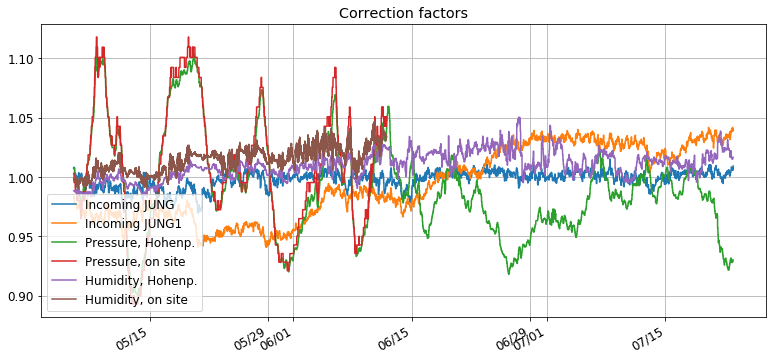

In [30]:
plt.rc('font', **{'size'   : 12})
fig = plt.figure(figsize=(13, 6))
ax = plt.subplot(111)
plt.plot(fi["2019-05-06":].index, fi["2019-05-06":], label="Incoming JUNG")
plt.plot(fi2["2019-05-06":].index, fi2["2019-05-06":], label="Incoming JUNG1")
plt.plot(fp["2019-05-06":].index, fp["2019-05-06":], label="Pressure, Hohenp.")
plt.plot(fp2["2019-05-06":].index, fp2["2019-05-06":], label="Pressure, on site")
plt.plot(fwv["2019-05-06":].index, fwv["2019-05-06":], label="Humidity, Hohenp.")
plt.plot(fwv2["2019-05-06":].index, fwv2["2019-05-06":], label="Humidity, on site")
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Correction factors")
plt.legend(loc="lower left")
fig.autofmt_xdate() 

In [31]:
crns20c = crns20.copy()
for id in crns20c.keys():
    crns20c[id] = crns20c[id] * fwv / (fi * fp)

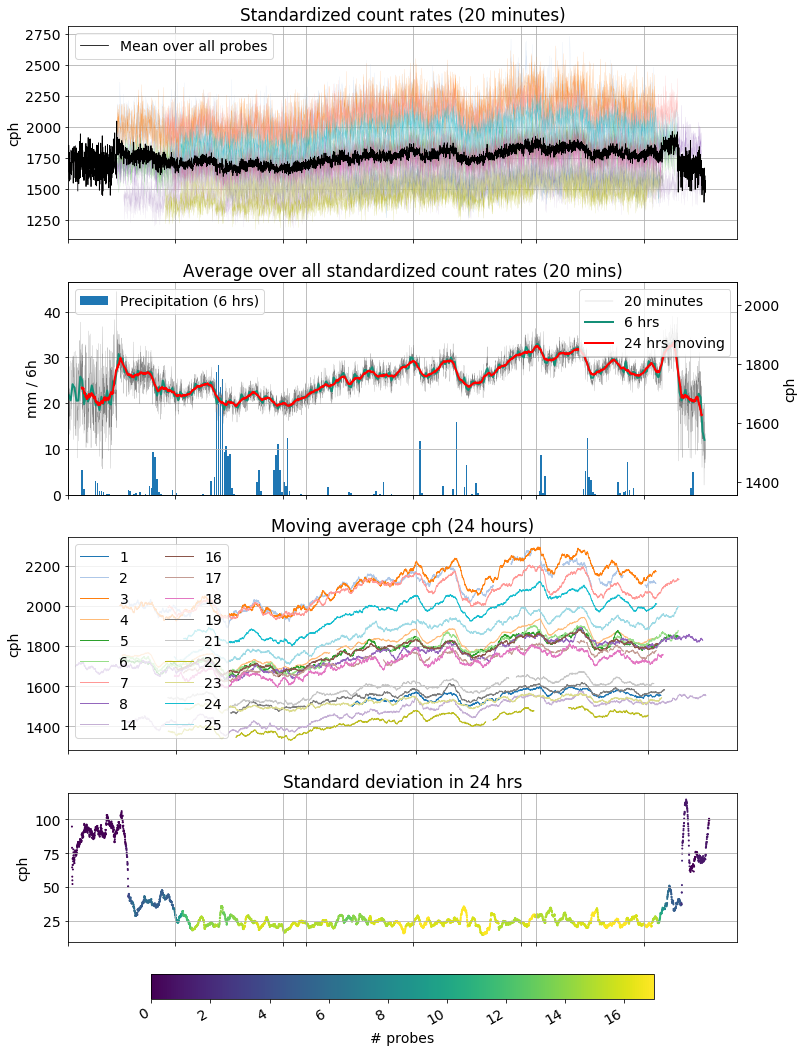

In [32]:
plt.rc('font', **{'size'   : 14})
ids = np.array(attrs[attrs.hasdata].id)
colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=4, figsize=(12,20))

plt.sca(ax[0])
for i, id in enumerate(ids):
    plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0.1)
mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
#plt.legend(ncol=2)
#plt.ylim(6500, 10000)
plt.grid()
plt.title("Standardized count rates (20 minutes)")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.legend(mpl, ["Mean over all probes"])
plt.ylabel("cph")

plt.sca(ax[1])
#plt.plot(prec["2019-05-01":].index, prec["2019-05-01":].depth.cumsum(), "--", color="black")
#plt.plot(meteo["2019-05-01":].index, meteo["2019-05-01":].precip.cumsum(), "--", color="blue")
#tmp = meteo.precip.resample("6H", loffset=dt.timedelta(hours=3)).sum()
tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
plt.legend(loc="upper left")
plt.grid()
plt.ylabel("mm / 6h")

ax2 = ax[1].twinx()
plt.plot(crns20c.index, crns20c[ids].mean(axis=1), lw=0.2, color="grey", label="20 minutes")
tmp = crns20c[ids].mean(axis=1).resample("6H", closed="right", loffset=dt.timedelta(hours=3)).mean()
plt.plot(tmp.index, tmp, lw=2, label="6 hrs", color="#148f77")
#tmp = crns20c[ids].mean(axis=1).resample("24H", closed="right", loffset=dt.timedelta(hours=12)).mean()
#plt.plot(tmp.index, tmp, lw=2, label="24 hrs", color="#e67e22")
tmp = crns20c[ids].mean(axis=1).rolling("24H", min_periods=3*24-5).mean()
plt.plot(tmp.index-dt.timedelta(hours=12), tmp, lw=2, color="red", label="24 hrs moving")
plt.xlim(ax[0].get_xlim())
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.ylim(7600, 8600)
#plt.grid()
plt.legend(loc="upper right")
plt.title("Average over all standardized count rates (20 mins)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.ylabel("cph")

plt.sca(ax[2])
crns24hchst = crns20c.resample("24H").mean()
for i, id in enumerate(ids):
    tmp = crns20c[id].rolling("24H", min_periods=3*24-10).mean()
    plt.plot(tmp.index-dt.timedelta(hours=12), tmp, lw=1, color=colors[i], label=(str(id)))
    #plt.plot(crns24hchst.index+dt.timedelta(hours=12), crns24hchst[id], color=colors[i])
#plt.ylim(7600, 8800)
plt.grid()
plt.title("Moving average cph (24 hours)")
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.legend(ncol=2, loc="upper left")
plt.ylabel("cph")

plt.sca(ax[3])
#tmp = crns20c[ids[1:]].mean(axis=1).resample("24H").std()
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1).rolling("24H").min()
cp = plt.scatter(tmp.index + dt.timedelta(hours=12), tmp, c=np.array(tmp2), s=1)
cb = plt.colorbar(cp, orientation="horizontal", shrink=0.75)
cb.set_label("# probes")
plt.xlim(ax[0].get_xlim())
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.grid()
plt.title("Standard deviation in 24 hrs")
plt.ylabel("cph")

fig.autofmt_xdate() 
#plt.tight_layout()

## Organize soil moisture campaign data

In [33]:
import folium
from pyproj import Transformer
from scipy import spatial
from matplotlib.colors import rgb2hex
from scipy.interpolate import griddata
from scipy.optimize import minimize

In [34]:
locs = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_merged.xlsx", sheet_name="locations")
locs = locs.set_index(locs.columns[0])

In [35]:
cyls = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_merged.xlsx", sheet_name="cylinder samples_lab results")

### Project geographic coordinates to Cartesian SRS (UTM 32 N)

In [36]:
transformer = Transformer.from_crs(4326, 32632, always_xy=True)
retransformer = Transformer.from_crs(32632, 4326, always_xy=True)

In [37]:
attrs["x"], attrs["y"] = transformer.transform(attrs.lon.tolist(), attrs.lat.tolist())
locs["x"], locs["y"] = transformer.transform(locs.lon_adjusted.tolist(), locs.lat_adjusted.tolist())

### Relate CRNS locations to sampling locations

In [38]:
# Find the closest CRNS location for each sampling location
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(crnsxy)
nextdist, nextix = tree.query(np.array([locs.x, locs.y]).T, k=1)
locs["crnsid"] = attrs.index[nextix]

In [39]:
# Assign a cylinder location ID to each CRNS in attribute table
attrs["cylid"] = -9999
for locid in np.unique(cyls["location_id"]):
    attrs.loc[locs.loc[locid, "crnsid"], "cylid"] = locid
# Assign cylinder stats to each CRNS in attribute table
attrs["rhob"] = np.nan
attrs["theta"] = np.nan

### Extract profile information from cylinder data

In [40]:
depths = 6
reps = 2

In [41]:
bd = {} # bulk density profiles
theta = {} # theta profiles
for i, id in enumerate(attrs.index):
    if id in [4,20]:
        # no cylinders for CRNS 4 and calibrator
        continue
    locid = attrs.loc[id, "cylid"]
    locdata = cyls[cyls["location_id"]==locid]
    locbd = np.array(locdata["BD (g/cm³)"]).reshape((-1,2))
    loctheta = np.array(locdata["volumetric water content (vol frac)"]).reshape((-1,2))
    bd[id] = locbd[0:6]
    theta[id] = loctheta[0:6]

### Retrieve mean profiles and fit standard shape functions to profiles

In [42]:
# Average bulk density profile
avgbd = np.array([bd[key].mean(axis=1) for key in bd.keys()]).mean(axis=0)
# Average theta profile
avgtheta = np.nanmean([np.nanmean(theta[key], axis=1) for key in theta.keys()], axis=0)

In [43]:
def profbd(depth, upper, lower, thresh):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + ((lower - upper)/thresh) * depth
    minbd = min(upper, lower)
    maxbd = max(upper, lower)
    y[y > maxbd] = maxbd
    y[y < minbd] = minbd
    return(y)    

In [44]:
def proftheta(depth, upper, lower):
    """Standard theta profile shape in Fendt    
    """
    y = upper + ((lower - upper)/25.) * depth
    return(y) 

In [45]:
obsdepths = np.arange(0,30,5)

In [46]:
def objfun(pars, proffun, obsprof, depths):
    fitprof = proffun(depths, *pars)
    return( np.sum((obsprof - fitprof)**2) )

In [47]:
# Optimal parameters for profile shape of average profile
avgopt = minimize(fun=objfun, x0=[0.5,1.5,5], args=(profbd, avgbd, obsdepths))

In [48]:
bdpars = {}
thetapars = {}
#attrs["bd"] = np.nan
#attrs["theta"] = np.nan
for i, id in enumerate(attrs.index):
    if id in [4,20]:
        continue
    bdpars[id] = minimize(fun=objfun, x0=avgopt["x"], args=(profbd, bd[id].mean(axis=1), obsdepths))["x"]    
    thetapars[id] = minimize(fun=objfun, x0=np.array([0.4, 0.5]), args=(proftheta, np.nanmean(theta[id], axis=1), obsdepths))["x"]    
    #attrs.loc[id, "bd"] = np.nanmean(bd[id])
    #attrs.loc[id, "theta"] = np.nanmean(theta[id])    

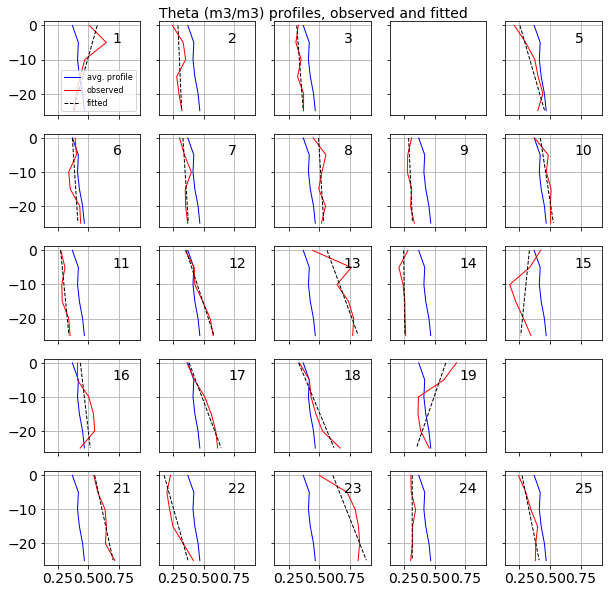

In [49]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,25,0.1)
for i, id in enumerate(attrs.index):
    if id in [4,20]:
        continue
    ax[i].plot(avgtheta, -obsdepths, lw=1, color="blue", label="avg. profile")
    ax[i].plot(np.nanmean(theta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(proftheta(plotdepths, *thetapars[id]), -plotdepths, lw=1, color="black", linestyle="dashed", label="fitted")
    #ax[i].set_title(str(id))
    ax[i].text(.7,-5,str(id))
    ax[i].grid()
    if i==0:
        ax[i].legend(loc="lower right", fontsize=8)
title = fig.suptitle("Theta (m3/m3) profiles, observed and fitted", y=0.9, fontsize=14)
#plt.tight_layout(h_pad=0.5)

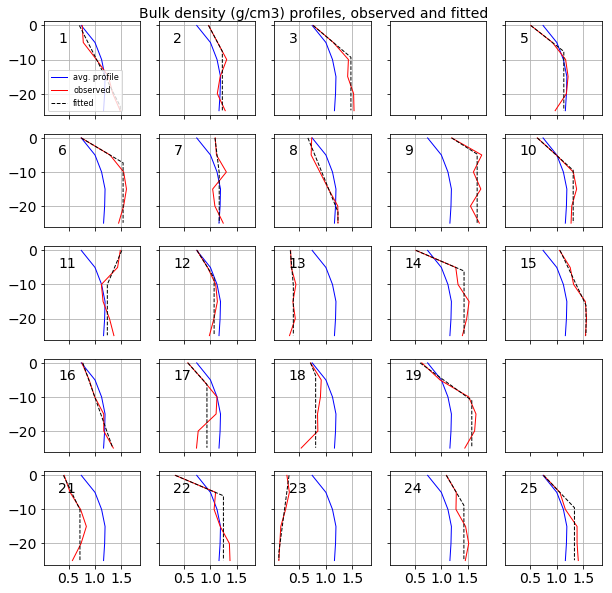

In [50]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10,10), sharex=True, sharey=True)
ax = ax.ravel()
plotdepths = np.arange(0,25,0.1)
for i, id in enumerate(attrs.index):
    if id in [4,20]:
        continue
    ax[i].plot(avgbd, -obsdepths, lw=1, color="blue", label="avg. profile")
    ax[i].plot(bd[id].mean(axis=1), -obsdepths, lw=1, color="red", label="observed")
    ax[i].plot(profbd(plotdepths, *bdpars[id]), -plotdepths, lw=1, color="black", linestyle="dashed", label="fitted")
    ax[i].text(.3,-5,str(id))
    ax[i].grid()
    if i==0:
        ax[i].legend(loc="lower left", fontsize=8)
title = fig.suptitle("Bulk density (g/cm3) profiles, observed and fitted", y=0.9, fontsize=14)

### Interpolation on a regular grid

In [51]:
# Get grid extent
buffer = 100
llx, lly, urx, ury = locs.x.min()-buffer, locs.y.min()-buffer, locs.x.max()+buffer, locs.y.max()+buffer
llx, lly, urx, ury = np.round([llx, lly, urx, ury], -2)
print(ury - lly, urx-llx)
bbox = retransformer.transform([llx, urx], [lly, ury])

1400.0 1200.0


In [52]:
m = folium.Map(location=[47.828835, 11.065808], zoom_start=15, tiles="Stamen Toner")
colors = [rgb2hex(col) for col in plt.cm.nipy_spectral(np.linspace(0,1,len(attrs.index)))]
for id in attrs.index:
    folium.Circle(location=[attrs.loc[id].lat, attrs.loc[id].lon], radius=10, 
                  color="black", fill_color="black", fill_opacity=0.9, weight=1).add_to(m)

for id in locs.index:
    if id in cyls.location_id:
        color = "blue"#colors[np.where(attrs.index==locs.loc[id,"crnsid"])[0][0]]
    else:
        color="blue"
    #print(color)
    folium.Circle(location=[locs.loc[id].lat_adjusted, locs.loc[id].lon_adjusted], radius=5,
                  color=color, fill_color=None, fill_opacity=0.9, weight=2).add_to(m)

for id in np.unique(cyls.location_id):
    try:
        folium.Circle(location=[locs.loc[id].lat_adjusted, locs.loc[id].lon_adjusted], radius=5,
                      color="red", fill_color=None, fill_opacity=0.9, weight=2).add_to(m)
    except KeyError:
        print(id)

folium.Rectangle(bounds=[(bbox[1][0], bbox[0][0]), (bbox[1][1], bbox[0][1])], 
                 color="orange", fill_color=None, weight=1).add_to(m)
m

In [53]:
# Construct grid
delta = 10
xs = np.arange(llx, urx+delta, delta)
ys = np.arange(lly, ury+delta, delta)
xx, yy = np.meshgrid(xs, ys)
xxyy = np.array([xx.ravel(), yy.ravel()]).T

In [54]:
# Organize input arrays for gridding
profx = [attrs.loc[id, "x"] for id in bdpars.keys()]
profy = [attrs.loc[id, "y"] for id in bdpars.keys()]
profxy = np.array([profx, profy]).T
# Bulk density
bdupper = [bdpars[id][0] for id in bdpars.keys()] 
bdlower = [bdpars[id][1] for id in bdpars.keys()]
bdthresh = [bdpars[id][2] for id in bdpars.keys()]
bdavgs = [np.nanmean(bd[id]) for id in bd.keys()]
# Theta
thetaupper = [thetapars[id][0] for id in thetapars.keys()] 
thetalower = [thetapars[id][1] for id in thetapars.keys()]
thetaavgs = [np.nanmean(theta[id]) for id in theta.keys()]

In [55]:
def idw(xy, values, gridxy, k=4, p=2.):
    tree = spatial.KDTree(xy)
    dists, ix = tree.query(gridxy, k=k)
    weights = 1.0 / dists ** p
    interpol = (np.sum(weights * np.array(values)[ix], axis=1) / np.sum(weights, axis=1))
    return(interpol)

In [56]:
ip_bdupper = idw(profxy, bdupper, xxyy)
ip_bdlower = idw(profxy, bdlower, xxyy)
ip_bdthresh = idw(profxy, bdthresh, xxyy)
ip_bdavg = idw(profxy, bdavgs, xxyy)

In [57]:
ip_thetaupper = idw(profxy, thetaupper, xxyy)
ip_thetalower = idw(profxy, thetalower, xxyy)
ip_thetaavg = idw(profxy, thetaavgs, xxyy)

In [58]:
def profbd2d(depth, upper, lower, thresh):
    """Standard bulk density profile shape in Fendt    
    """
    y = upper + ((lower - upper)/thresh) * depth
    minbd = np.min([upper, lower], axis=0)
    maxbd = np.max([upper, lower], axis=0)
    y = np.where(y > maxbd, maxbd, y)
    y = np.where(y < minbd, minbd, y)
    return(y)  

In [59]:
bd_from_fit = profbd2d(np.arange(0,30).reshape((-1,1)), ip_bdupper, ip_bdlower, ip_bdthresh).mean(axis=0)

In [60]:
theta_from_fit = proftheta(np.arange(0,30).reshape((-1,1)), ip_thetaupper, ip_thetalower).mean(axis=0)

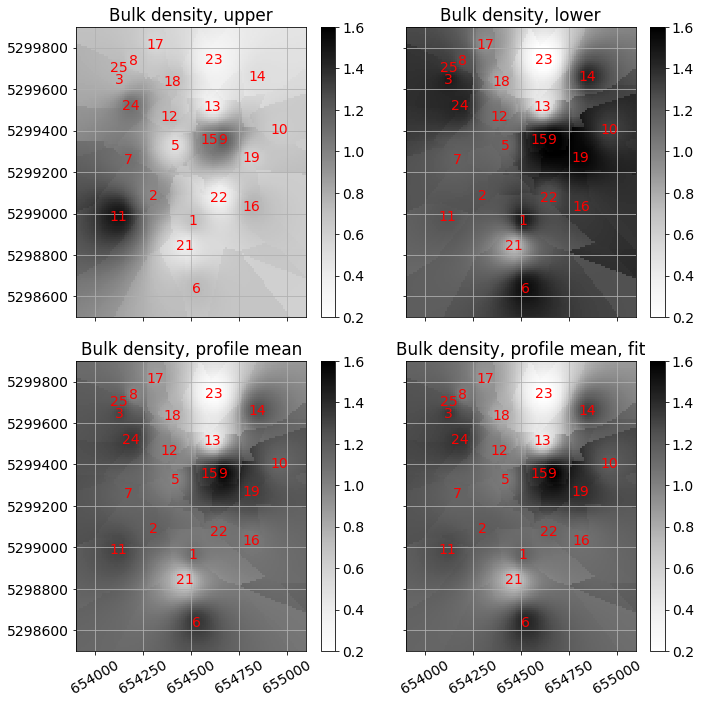

In [65]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True, sharey=True)

vmin=0.2
vmax=1.6

cmap = plt.cm.Greys

plt.sca(ax[0,0])
p = plt.pcolormesh(xx, yy, ip_bdupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
plt.title("Bulk density, upper")
plt.grid()


plt.sca(ax[0,1])
p = plt.pcolormesh(xx, yy, ip_bdlower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
plt.title("Bulk density, lower")
plt.grid()

plt.sca(ax[1,0])
p = plt.pcolormesh(xx, yy, ip_bdavg.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
plt.grid()
plt.title("Bulk density, profile mean")
plt.xticks(rotation=30)

plt.sca(ax[1,1])
p = plt.pcolormesh(xx, yy, bd_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
plt.grid()
plt.title("Bulk density, profile mean, fit")
plt.xticks(rotation=30)
plt.tight_layout()

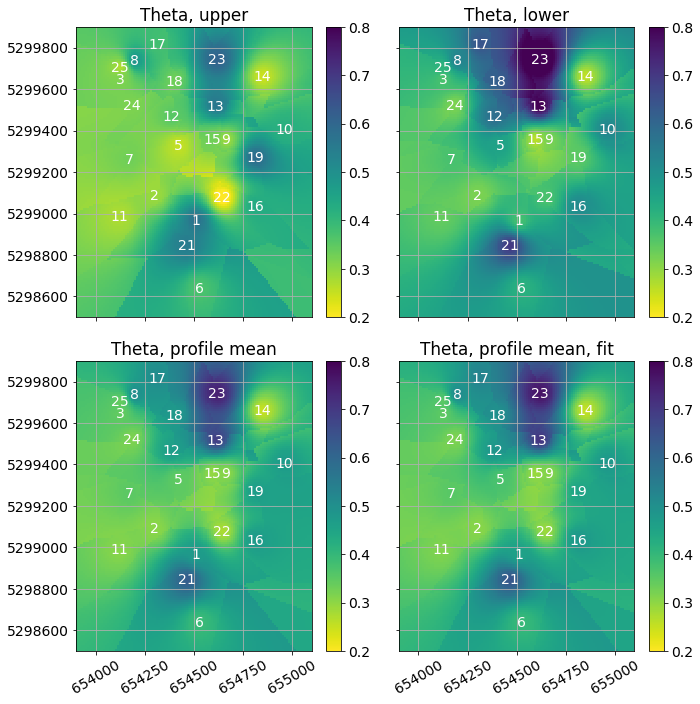

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex=True, sharey=True)

vmin=0.2
vmax=0.8

plt.sca(ax[0,0])
p = plt.pcolormesh(xx, yy, ip_thetaupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=plt.cm.viridis_r)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="white")
plt.title("Theta, upper")
plt.grid()

plt.sca(ax[0,1])
p = plt.pcolormesh(xx, yy, ip_thetalower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=plt.cm.viridis_r)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="white")
plt.title("Theta, lower")
plt.grid()

plt.sca(ax[1,0])
p = plt.pcolormesh(xx, yy, ip_thetaavg.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=plt.cm.viridis_r)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="white")
plt.grid()
plt.title("Theta, profile mean")
plt.xticks(rotation=30)

plt.sca(ax[1,1])
p = plt.pcolormesh(xx, yy, theta_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=plt.cm.viridis_r)
plt.colorbar(p)
for id in bdpars.keys():
    text_object = plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="white")
plt.grid()
plt.title("Theta, profile mean, fit")
plt.xticks(rotation=30)

plt.tight_layout()

### Compute bulk density and average soil moisture per CRNS probe

In [66]:
crnsxy = np.array([attrs.x, attrs.y]).T
tree = spatial.KDTree(xxyy)
ix = tree.query_ball_point(crnsxy, r=150)

In [67]:
def distance(pt, pts):
    return np.sqrt((pts[:,0] - pt[0])**2 + (pts[:,1] - pt[1])**2)

In [68]:
dists = {}
hweights = {}
attrs["theta_havg"] = np.nan
attrs["bd_havg"] = np.nan
for i, id in enumerate(attrs.index):
    dists[id] = distance(crnsxy[i], xxyy[ix[i]])
    hweights[id] = cs.core.horizontal_weight_koehli_approx(dists[id]) / (2 * np.pi * dists[id])
    attrs.loc[id,"bd_havg"] = np.sum(bd_from_fit[ix[i]] * hweights[id] / np.sum(hweights[id]))
    attrs.loc[id,"theta_havg"] = np.sum(theta_from_fit[ix[i]] * hweights[id] / np.sum(hweights[id]))

### Calibrate N0 parameter

In [69]:
h24 = crns20c.rolling("24H", min_periods=int(3*24*0.8)).mean()

In [70]:
from scipy.optimize import minimize_scalar

In [71]:
def objtheta(n0, cph, dtimes, rhob, obstheta, porosity):
    tmp = cs.core.n_to_theta_desilets(cph, n0, rhob=rhob)
    x = np.nanmean(tmp[dtimes[0]:dtimes[1]])
    error = np.abs(obstheta - x)
    exc = tmp - porosity
    exc[exc < 0] = 0
    exc = exc[~np.isnan(exc)]
    excerror = np.quantile(exc,0.9) + np.sum(tmp>1.)
    totalerror = np.mean([excerror, error])
    #print(n0, error, excerror, totalerror)
    return totalerror

In [72]:
caltimes = ["2019-06-25 08:00:00", "2019-06-26 18:00:00"]
attrs["n0"] = np.nan
for id in attrs.index[attrs.hasdata]:
    #print(id)
    cphin = h24[id].apply(copy.deepcopy)
    rhob = attrs.loc[id, "bd_havg"] * 1000.
    obstheta = attrs.loc[id, "theta_havg"]
    porosity = 1 - rhob / 2.65e3
    optres = minimize_scalar(objtheta, args=(cphin, caltimes, rhob, obstheta, porosity))
    #print(id, optres.fun, optres.x)
    if not np.isnan(optres.fun):
        attrs.loc[id,"n0"] = optres["x"]

In [73]:
crnstheta = h24.apply(copy.deepcopy)
for id in attrs.index[attrs.hasdata]:
    crnstheta[id] = cs.core.n_to_theta_desilets(h24[id].copy(), n0=attrs.loc[id,"n0"], rhob=attrs.loc[id, "bd_havg"]*1000)

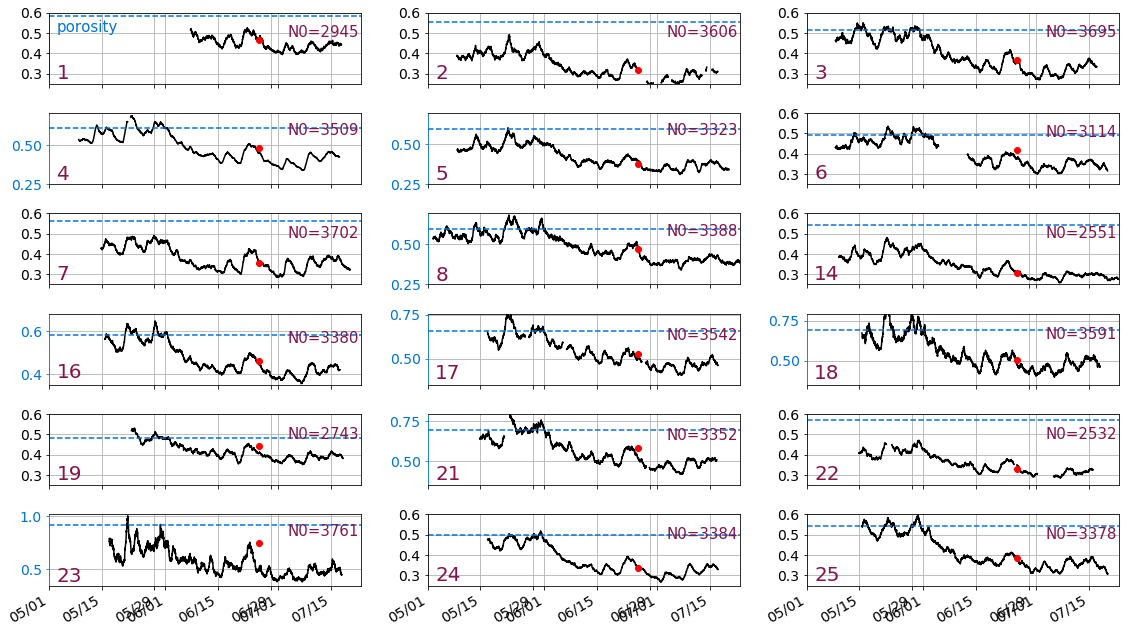

In [82]:
plt.rc('font', **{'size'   : 14})
ids = np.array(attrs[attrs.hasdata].id)
colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(16,9), sharex=True)
ax = ax.ravel()

for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    #if id==3:
    #    tmp=cs.core.n_to_theta_desilets(0.92*h24[id], n0=3400, rhob=attrs.loc[3, "bd_havg"]*1000)
    #    plt.plot(tmp.index+dt.timedelta(hours=12), tmp, color="black")
    #else:
    plt.plot(crnstheta.index+dt.timedelta(hours=12), crnstheta[id], color="black")
    ymin = 0.25
    ymax = 0.6
    if crnstheta[id].max() > 0.6:
        ymax = 0.1 + 1-attrs.loc[id, "bd_havg"]/2.65# np.round(crnstheta[id].max(),1)
        ymin = np.round(crnstheta[id].min(),1)-0.05
        ax[i].spines['left'].set_color("#0074D9")
        ax[i].tick_params(axis='y', colors="#0074D9")
    plt.grid()
    plt.ylim(ymin, ymax)
    #plt.title("Theta (24 hours)")
    #plt.ylabel("m3/m3")
    plt.plot(dt.datetime(2019,6,26,0,0,0), attrs.loc[id, "theta_havg"], "ro")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xlim(min_dtime-dt.timedelta(hours=1), max_dtime)
    plt.axhline(y=1-attrs.loc[id, "bd_havg"]/2.65, linestyle="dashed", color="#0074D9")
    plt.text(dt.datetime(2019,5,3), 1.1*ymin, str(id), color="#85144b", fontsize=20)
    plt.text(crnstheta.index[-1400], 0.8*ymax, "N0=%d" % int(attrs.loc[id, "n0"]), color="#85144b", fontsize=15)
    if i==0:
        plt.text(dt.datetime(2019,5,3), 1-attrs.loc[id, "bd_havg"]/2.65 - 0.08, "porosity", color="#0074D9", fontsize=15)

fig.autofmt_xdate() 
plt.tight_layout()

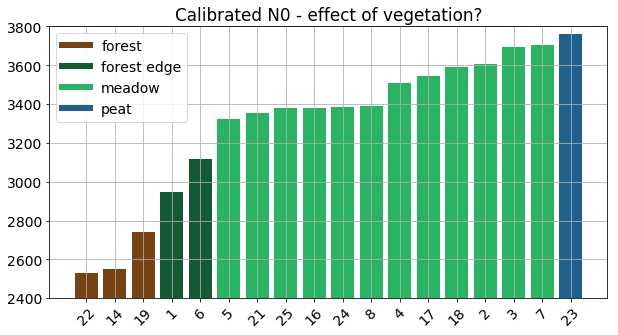

In [92]:
n0arr = np.array(attrs.n0[attrs.hasdata])
n0ids = np.array(attrs.index[attrs.hasdata])
forestcol = ["#784212"]
edgecol = ["#145a32"]
meadowcol = ["#28b463"]
turfcol = ["#1f618d"]
legend_elements = [plt.Line2D([0], [0], color=forestcol[0], lw=6, label="forest"),
                plt.Line2D([0], [0], color=edgecol[0], lw=6, label="forest edge"),
                plt.Line2D([0], [0], color=meadowcol[0], lw=6, label="meadow"),
                plt.Line2D([0], [0], color=turfcol[0], lw=6, label="peat")]

colors = forestcol*3 + edgecol*2 + meadowcol*12 + turfcol
sortix = np.argsort(n0arr)
fig, ax = plt.subplots(figsize=(10,5))
xticks = np.arange(len(n0arr))
plt.bar(xticks, n0arr[sortix], color=colors)
plt.xticks(xticks)
_ = ax.set_xticklabels(n0ids[sortix], rotation=45 )
plt.grid()
plt.ylim(2400,3800)
_ = plt.title("Calibrated N0 - effect of vegetation?")
ax.legend(handles=legend_elements)

## Construct gridded series of theta from calibrated CRNS

In [93]:
def normfunc(x):
    x = 100 * x / np.sum(x)
    return x

In [94]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
allw = np.zeros((np.sum(attrs.hasdata), len(xxyy)))
for i, id in enumerate(attrs.index[attrs.hasdata]):
    dist = distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist)# / (2 * np.pi * dist)
    #w = cs.core.horizontal_weight_zreda2008b(dist)
    w[dist>300] = 0
    allw[i] = w#normfunc(w)

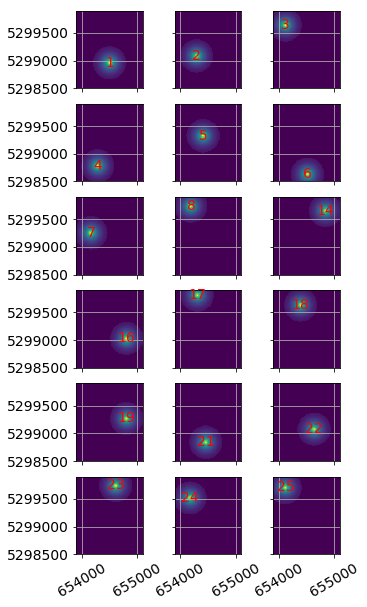

In [125]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(5,10),sharex=True, sharey=True)
ax=ax.ravel()


for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    ax[i].set_aspect('equal')
    p=plt.pcolormesh(xx, yy, allw[i].reshape(xx.shape), vmax=1)
    plt.grid()
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
    plt.xticks(rotation=30)
    #lt.colorbar(p)
#plt.tight_layout()

In [101]:
sli = crnstheta["2019-05-01":"2019-07-15"].resample("12H").mean()
vals = np.zeros((len(sli),len(xxyy)))
for i in range(len(sli)):
    tmp = np.array(sli.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    vals[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)

/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [97]:
catchm = shapefile.Reader("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/upperRottCatchment.shp")
roads = shapefile.Reader("/media/x/cosmicsense/data/fendt/data_v1/Elaborated/FendtRoads.shp")

In [98]:
catchmcoords = [np.array(cat.points) for cat in catchm.shapes()]
catchmcoords = [transformer.transform(coords[:,0], coords[:,1]) for coords in catchmcoords]

In [99]:
roadscoords = [np.array(road.points) for road in roads.shapes()]
roadscoords = [transformer.transform(coords[:,0], coords[:,1]) for coords in roadscoords]

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg': 'ffmpeg'

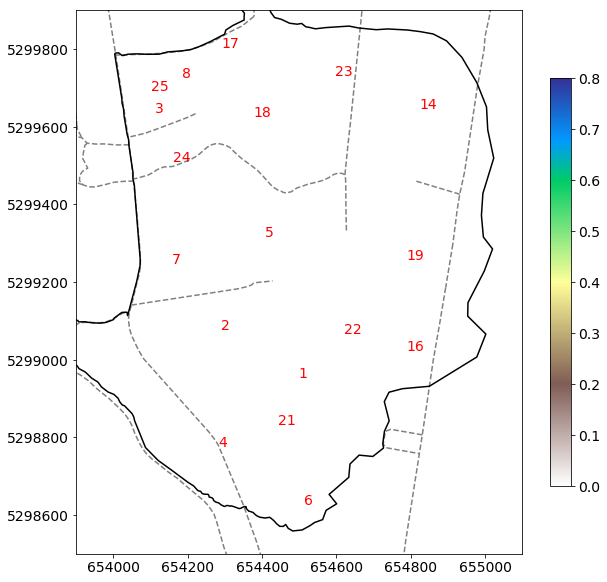

In [113]:
fig, ax = plt.subplots(figsize=(10,10))
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax.pcolormesh(xx, yy, vals[0].reshape(xx.shape), vmin=0.0, vmax=0.8, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index[attrs.hasdata]:
    text_object = ax.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
for road in roadscoords:
    ax.plot(road[0], road[1], "grey", linestyle="dashed")
ax.plot(catchmcoords[0][0], catchmcoords[0][1], color="black")
ax.grid(color="white")
tstamp = ax.set_title("")
plt.colorbar(quad1, shrink=0.75)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

def init():
    quad1.set_array([])
    return quad1

def animate(iter):
    arr = vals[iter].reshape(xx.shape)[:-1, :-1]
    quad1.set_array(arr.ravel())
    #quad1.set_array(vals[iter].reshape(xx.shape))
    tstamp.set_text(sli.index[iter].isoformat())
    
    return quad1


anim = animation.FuncAnimation(fig,animate,frames=len(vals),interval=250,blit=False,repeat=False)
tmp = anim.save('theta_animation.gif', writer='imagemagick')

In [105]:
animation.writers

![SegmentLocal](basic_example.gif "segment")